In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
def create_graph(df) -> dict:
    """
    returns a didct with keys = node key, and values = edges (node_id, edge weight) 
    """
    tree = {}
    for _, row in df.iterrows():
        parent = row['Parent']
        child = row['Child']
        weight = row['t']

        # root node
        if pd.isna(parent): 
            continue
        # node already exists
        elif parent in tree: 
            tree[parent].append((child, weight))
        # node does not exists
        else:
            tree[parent] = [(child, weight)]
    return tree


def pd_z0():
    return max(np.random.normal(alpha_0, np.sqrt(variance_0)), 1)


def cpd(z, t):
    mean = gamma_0 + (alpha * t) + (beta * z) + (gamma * t * z)
    var = variance * t
    return max(np.random.normal(mean, np.sqrt(var)), 1)


def simulation(root: int, z0: float, graph: dict) -> dict:
    """
    BFS
    returns z value for all 407 nodes
    """
    results = {root: z0}  # init results with root=z0
    queue = [(root, z0)]

    while queue:
        node, z = queue.pop(0)
        results[node] = z
        
        children = graph.get(node, [])

        if not children:
            continue
        else:
            for child in children:
                id, t = child
                queue.append((id, cpd(z, t)))

    return results


def n_simulations(n:int, root:int, graph:dict):
    """
    only returns values for X_i ... X_204 
    """
    X, y = [], []

    for i in range(n):
        z0 = pd_z0()
        x = simulation(root, z0, graph)
        
        X.append([x.get(i) for i in range(1, 205)])  # get the z values for X_1 to X_204 only
        y.append(z0)
 
    return np.array(X), np.array(y)


def dfs_paths_with_cpd(graph, start_node, z, path=None):
    # returns all paths and the gene length at each node in the path
    if path is None:
        path = [(start_node, z)]

    if start_node not in graph:
        return [path]

    paths = []
    for child, t in graph[start_node]:
        if child not in [node for node, _ in path]:
            new_z = cpd(z, t)
            child_paths = dfs_paths_with_cpd(graph, child, new_z, path + [(child, new_z)])
            paths.extend(child_paths)

    return paths

In [3]:
# load data
tree_data = pd.read_csv('data/tree.csv')
genes_data = pd.read_csv('data/vert_genes.csv')

# remove root node, since we already have reference to it from else where. unless issue with t?
tree_data = tree_data[tree_data['Parent'].notna()]

# convert parent col to ints
tree_data['Parent'] = tree_data['Parent'].astype(int)

In [4]:
# gamma_0 + (alpha * time) (beta * parent gene len) + (gamma * time * parent gene len)

# Parameters
# for Z_0
alpha_0 = 50000
variance_0 = 5000

# for Z_i and X_i
alpha = 0.15
beta = 1.05
variance = 2500 

# for conditional mean with the gamma influence 
gamma_0 = 3
gamma = 0.01

# Settings
root = 407
num_of_samples = 10000

# create a dict graph
graph = create_graph(tree_data)

In [5]:
# Create data
t0 = time.time()
X, y = n_simulations(n=num_of_samples, root=root, graph=graph)
runtime = time.time() - t0
print(f"{runtime:.10f} sec")

15.5590527058 sec


In [6]:
# lin reg
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
reg = LinearRegression().fit(X_train, y_train)

# Train results
yt_pred = reg.predict(X_train)
train_r2 = reg.score(X_train, y_train)
train_mse = mean_squared_error(y_train, yt_pred)

# Test results
y_pred = reg.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)

print(f"TRAIN. r2: {train_r2:.3f}, MSE: {train_mse:.3f}")
print(f"TEST. r2: {test_r2:.3f}, MSE: {test_mse:.3f}")

TRAIN. r2: 0.415, MSE: 2860.665
TEST. r2: 0.375, MSE: 3117.892


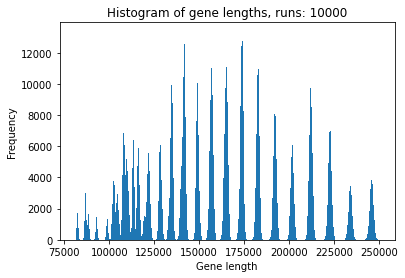

In [7]:
plt.hist(X.flatten(), bins=int(num_of_samples/10))

plt.xlabel('Gene length')
plt.ylabel('Frequency')
plt.title(f'Histogram of gene lengths, runs: {num_of_samples}')
plt.show()

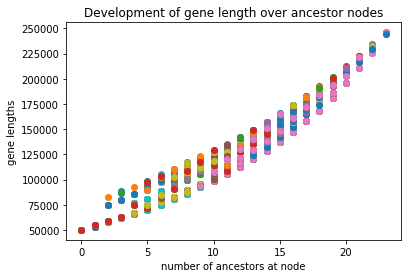

In [8]:
# all paths with their respective z values at each node in the path
paths_with_z = dfs_paths_with_cpd(graph=graph, start_node=407, z=pd_z0())

# plot development of gene length for all paths
# longest = max(paths_with_z, key=len)  # plot the path with the most ancestors
for index, path in enumerate(paths_with_z):
    ys = [y[1] for y in path]
    plt.scatter(range(len(ys)), ys)

plt.xlabel('number of ancestors at node')
plt.ylabel('gene lengths')
plt.title('Development of gene length over ancestor nodes')
plt.show()

In [9]:
# load data
treedat = pd.read_csv('data/tree.csv')
genesdat = pd.read_csv('data/vert_genes.csv')

In [10]:
# 205 from the nan present
len(treedat['species'].unique())

205

In [11]:
len(genesdat['species'].unique())

204

In [12]:
len(genesdat['orthId'].unique())

10

In [13]:
# group species by the orthid
grouped = genesdat.groupby('orthId')['species'].agg(list).reset_index()
grouped['species'][4] == grouped['species'][2]

False

In [14]:
grouped['species'][0]  # gene 0

['Acanthisitta_chloris',
 'Anas_platyrhynchos',
 'Anser_cygnoides',
 'Apaloderma_vittatum',
 'Aptenodytes_forsteri',
 'Apteryx_australis',
 'Aquila_chrysaetos',
 'Balearica_regulorum',
 'Buceros_rhinoceros',
 'Calidris_pugnax',
 'Calypte_anna',
 'Caprimulgus_carolinensis',
 'Cariama_cristata',
 'Chaetura_pelagica',
 'Charadrius_vociferus',
 'Chlamydotis_macqueenii',
 'Colius_striatus',
 'Columba_livia',
 'Corvus_brachyrhynchos',
 'Corvus_cornix',
 'Coturnix_japonica',
 'Cuculus_canorus',
 'Egretta_garzetta',
 'Eurypyga_helias',
 'Falco_cherrug',
 'Falco_peregrinus',
 'Ficedula_albicollis',
 'Fulmarus_glacialis',
 'Gallus_gallus',
 'Gavia_stellata',
 'Geospiza_fortis',
 'Haliaeetus_albicilla',
 'Haliaeetus_leucocephalus',
 'Lepidothrix_coronata',
 'Leptosomus_discolor',
 'Meleagris_gallopavo',
 'Melopsittacus_undulatus',
 'Merops_nubicus',
 'Mesitornis_unicolor',
 'Nestor_notabilis',
 'Nipponia_nippon',
 'Opisthocomus_hoazin',
 'Parus_major',
 'Pelecanus_crispus',
 'Phaethon_lepturus',
